In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

AttentionWithContext.py		 roc_auc_callback.py	X_val.npy
colab_setup.py			 sample_submission.csv	y_test.npy
custom_fast_text_embeddings.npy  train_model.py		y_train_full.npy
datalab				 X_submission.npy	y_train.npy
fast_text_embeddings.npy	 X_test.npy		y_val.npy
plot_history.py			 X_train_full.npy
__pycache__			 X_train.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
file_import = drive.CreateFile({'id':'1gV3lTGPAL-x0c-EqZXyF4saHo7AVLN4j'})
file_import.GetContentFile('AttentionWithContext.py') 

from AttentionWithContext import AttentionWithContext

In [0]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [10]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

features_1 = one_by_one(filtersNumber, embedding_dropout)
features_1 = AttentionWithContext()(features_1)
features_2 = one_by_one(filtersNumber, embedding_dropout)
features_2 = AttentionWithContext()(features_2)
features_3 = one_by_one(filtersNumber, embedding_dropout)
features_3 = AttentionWithContext()(features_3)

features = concatenate([features_1, features_2, features_3])

dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________

In [11]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21440/102124 [=====>........................] - ETA: 2:34 - loss: 0.1938 - acc: 0.9280

102112/102124 [============================>.] - ETA: 0s - loss: 0.1007 - acc: 0.9645

102124/102124 [==============================] - 201s 2ms/step - loss: 0.1007 - acc: 0.9645 - val_loss: 0.2016 - val_acc: 0.9666
Epoch 2/32
 14048/102124 [===>..........................] - ETA: 2:38 - loss: 0.0694 - acc: 0.9762

102112/102124 [============================>.] - ETA: 0s - loss: 0.0649 - acc: 0.9772

102124/102124 [==============================] - 199s 2ms/step - loss: 0.0649 - acc: 0.9771 - val_loss: 0.0773 - val_acc: 0.9765
roc-auc: 0.9753 - roc-auc_val: 0.9722                                                                                                    
Epoch 3/32
  8736/102124 [=>............................] - ETA: 2:49 - loss: 0.0567 - acc: 0.9799

102112/102124 [============================>.] - ETA: 0s - loss: 0.0578 - acc: 0.9789

102124/102124 [==============================] - 198s 2ms/step - loss: 0.0578 - acc: 0.9789 - val_loss: 0.0772 - val_acc: 0.9747
Epoch 4/32
 10176/102124 [=>............................] - ETA: 2:47 - loss: 0.0564 - acc: 0.9790

102112/102124 [============================>.] - ETA: 0s - loss: 0.0551 - acc: 0.9798

102124/102124 [==============================] - 199s 2ms/step - loss: 0.0551 - acc: 0.9798 - val_loss: 0.0599 - val_acc: 0.9799
roc-auc: 0.9831 - roc-auc_val: 0.9788                                                                                                    
Epoch 5/32
  8736/102124 [=>............................] - ETA: 2:50 - loss: 0.0503 - acc: 0.9812

102112/102124 [============================>.] - ETA: 0s - loss: 0.0533 - acc: 0.9804

102124/102124 [==============================] - 199s 2ms/step - loss: 0.0533 - acc: 0.9804 - val_loss: 0.0599 - val_acc: 0.9794
Epoch 6/32
 10176/102124 [=>............................] - ETA: 2:47 - loss: 0.0514 - acc: 0.9801

102112/102124 [============================>.] - ETA: 0s - loss: 0.0515 - acc: 0.9807

102124/102124 [==============================] - 199s 2ms/step - loss: 0.0515 - acc: 0.9807 - val_loss: 0.0623 - val_acc: 0.9782

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00029730176902376115.
roc-auc: 0.9854 - roc-auc_val: 0.9823                                                                                                    
Epoch 7/32
  5952/102124 [>.............................] - ETA: 2:54 - loss: 0.0502 - acc: 0.9814

102112/102124 [============================>.] - ETA: 0s - loss: 0.0500 - acc: 0.9812

102124/102124 [==============================] - 200s 2ms/step - loss: 0.0500 - acc: 0.9812 - val_loss: 0.0533 - val_acc: 0.9808
Epoch 8/32
 10176/102124 [=>............................] - ETA: 2:47 - loss: 0.0520 - acc: 0.9804

102112/102124 [============================>.] - ETA: 0s - loss: 0.0496 - acc: 0.9813

102124/102124 [==============================] - 198s 2ms/step - loss: 0.0496 - acc: 0.9813 - val_loss: 0.0555 - val_acc: 0.9804
roc-auc: 0.9858 - roc-auc_val: 0.9824                                                                                                    
Epoch 9/32
  8736/102124 [=>............................] - ETA: 2:50 - loss: 0.0516 - acc: 0.9806

102112/102124 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.9816

102124/102124 [==============================] - 199s 2ms/step - loss: 0.0487 - acc: 0.9816 - val_loss: 0.0514 - val_acc: 0.9816
Epoch 10/32
 10144/102124 [=>............................] - ETA: 2:47 - loss: 0.0493 - acc: 0.9813

102112/102124 [============================>.] - ETA: 0s - loss: 0.0477 - acc: 0.9818

102124/102124 [==============================] - 199s 2ms/step - loss: 0.0477 - acc: 0.9818 - val_loss: 0.0558 - val_acc: 0.9793
roc-auc: 0.9878 - roc-auc_val: 0.9839                                                                                                    
Epoch 11/32
  8704/102124 [=>............................] - ETA: 2:48 - loss: 0.0481 - acc: 0.9823

102112/102124 [============================>.] - ETA: 0s - loss: 0.0475 - acc: 0.9819

102124/102124 [==============================] - 198s 2ms/step - loss: 0.0475 - acc: 0.9819 - val_loss: 0.0516 - val_acc: 0.9805
Epoch 12/32
 10144/102124 [=>............................] - ETA: 2:45 - loss: 0.0457 - acc: 0.9824

102112/102124 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9821

102124/102124 [==============================] - 199s 2ms/step - loss: 0.0470 - acc: 0.9821 - val_loss: 0.0539 - val_acc: 0.9797
roc-auc: 0.9876 - roc-auc_val: 0.9836                                                                                                    
Epoch 13/32
  8704/102124 [=>............................] - ETA: 2:52 - loss: 0.0453 - acc: 0.9824

102112/102124 [============================>.] - ETA: 0s - loss: 0.0464 - acc: 0.9823

102124/102124 [==============================] - 199s 2ms/step - loss: 0.0464 - acc: 0.9823 - val_loss: 0.0511 - val_acc: 0.9808
Epoch 14/32
 10144/102124 [=>............................] - ETA: 2:44 - loss: 0.0470 - acc: 0.9818

102112/102124 [============================>.] - ETA: 0s - loss: 0.0461 - acc: 0.9823

102124/102124 [==============================] - 198s 2ms/step - loss: 0.0461 - acc: 0.9823 - val_loss: 0.0504 - val_acc: 0.9808
roc-auc: 0.9879 - roc-auc_val: 0.9841                                                                                                    
Epoch 15/32
  8704/102124 [=>............................] - ETA: 2:49 - loss: 0.0448 - acc: 0.9827

102112/102124 [============================>.] - ETA: 0s - loss: 0.0461 - acc: 0.9825

102124/102124 [==============================] - 201s 2ms/step - loss: 0.0461 - acc: 0.9825 - val_loss: 0.0515 - val_acc: 0.9807
Epoch 16/32
 10144/102124 [=>............................] - ETA: 2:46 - loss: 0.0446 - acc: 0.9830

102112/102124 [============================>.] - ETA: 0s - loss: 0.0456 - acc: 0.9823

102124/102124 [==============================] - 199s 2ms/step - loss: 0.0456 - acc: 0.9823 - val_loss: 0.0494 - val_acc: 0.9814
roc-auc: 0.9888 - roc-auc_val: 0.9852                                                                                                    
Epoch 17/32
  8704/102124 [=>............................] - ETA: 2:48 - loss: 0.0441 - acc: 0.9831

102112/102124 [============================>.] - ETA: 0s - loss: 0.0451 - acc: 0.9827

102124/102124 [==============================] - 199s 2ms/step - loss: 0.0451 - acc: 0.9827 - val_loss: 0.0541 - val_acc: 0.9798
Epoch 18/32
 10144/102124 [=>............................] - ETA: 2:47 - loss: 0.0461 - acc: 0.9823

102112/102124 [============================>.] - ETA: 0s - loss: 0.0454 - acc: 0.9827

102124/102124 [==============================] - 199s 2ms/step - loss: 0.0454 - acc: 0.9827 - val_loss: 0.0489 - val_acc: 0.9819
roc-auc: 0.9892 - roc-auc_val: 0.9858                                                                                                    
Epoch 19/32
  8704/102124 [=>............................] - ETA: 2:49 - loss: 0.0434 - acc: 0.9833

102112/102124 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9827

102124/102124 [==============================] - 199s 2ms/step - loss: 0.0450 - acc: 0.9827 - val_loss: 0.0477 - val_acc: 0.9821
Epoch 20/32
 10144/102124 [=>............................] - ETA: 2:46 - loss: 0.0453 - acc: 0.9824

102112/102124 [============================>.] - ETA: 0s - loss: 0.0447 - acc: 0.9828

102124/102124 [==============================] - 199s 2ms/step - loss: 0.0447 - acc: 0.9828 - val_loss: 0.0486 - val_acc: 0.9815
roc-auc: 0.9895 - roc-auc_val: 0.9862                                                                                                    
Epoch 21/32
  8704/102124 [=>............................] - ETA: 2:48 - loss: 0.0463 - acc: 0.9818

102112/102124 [============================>.] - ETA: 0s - loss: 0.0445 - acc: 0.9828

102124/102124 [==============================] - 198s 2ms/step - loss: 0.0445 - acc: 0.9828 - val_loss: 0.0513 - val_acc: 0.9807

Epoch 00021: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 22/32
  8064/102124 [=>............................] - ETA: 2:51 - loss: 0.0455 - acc: 0.9820

102112/102124 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9828

102124/102124 [==============================] - 199s 2ms/step - loss: 0.0444 - acc: 0.9828 - val_loss: 0.0488 - val_acc: 0.9817
roc-auc: 0.9896 - roc-auc_val: 0.9863                                                                                                    
Epoch 23/32
  8704/102124 [=>............................] - ETA: 2:50 - loss: 0.0451 - acc: 0.9824

102112/102124 [============================>.] - ETA: 0s - loss: 0.0442 - acc: 0.9830

102124/102124 [==============================] - 198s 2ms/step - loss: 0.0442 - acc: 0.9830 - val_loss: 0.0487 - val_acc: 0.9818
Epoch 24/32
 10144/102124 [=>............................] - ETA: 2:46 - loss: 0.0428 - acc: 0.9832

102112/102124 [============================>.] - ETA: 0s - loss: 0.0440 - acc: 0.9830

102124/102124 [==============================] - 199s 2ms/step - loss: 0.0440 - acc: 0.9830 - val_loss: 0.0519 - val_acc: 0.9804
roc-auc: 0.9898 - roc-auc_val: 0.986                                                                                                    
Epoch 25/32
  8736/102124 [=>............................] - ETA: 2:49 - loss: 0.0441 - acc: 0.9832

102112/102124 [============================>.] - ETA: 0s - loss: 0.0440 - acc: 0.9829

102124/102124 [==============================] - 200s 2ms/step - loss: 0.0440 - acc: 0.9829 - val_loss: 0.0481 - val_acc: 0.9821
Epoch 26/32
 10144/102124 [=>............................] - ETA: 2:47 - loss: 0.0448 - acc: 0.9830

102112/102124 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.9832

102124/102124 [==============================] - 199s 2ms/step - loss: 0.0439 - acc: 0.9832 - val_loss: 0.0482 - val_acc: 0.9816
roc-auc: 0.99 - roc-auc_val: 0.9865                                                                                                    
Epoch 27/32
  8768/102124 [=>............................] - ETA: 2:48 - loss: 0.0430 - acc: 0.9838

102112/102124 [============================>.] - ETA: 0s - loss: 0.0437 - acc: 0.9831

102124/102124 [==============================] - 200s 2ms/step - loss: 0.0437 - acc: 0.9831 - val_loss: 0.0514 - val_acc: 0.9802
Epoch 28/32
 10144/102124 [=>............................] - ETA: 2:46 - loss: 0.0459 - acc: 0.9823

102112/102124 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9832

102124/102124 [==============================] - 200s 2ms/step - loss: 0.0438 - acc: 0.9831 - val_loss: 0.0492 - val_acc: 0.9814
roc-auc: 0.9894 - roc-auc_val: 0.9857                                                                                                    
Epoch 29/32
  8704/102124 [=>............................] - ETA: 2:52 - loss: 0.0433 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0435 - acc: 0.9831

102124/102124 [==============================] - 201s 2ms/step - loss: 0.0435 - acc: 0.9831 - val_loss: 0.0476 - val_acc: 0.9826
Epoch 30/32
 10144/102124 [=>............................] - ETA: 2:48 - loss: 0.0426 - acc: 0.9833

102112/102124 [============================>.] - ETA: 0s - loss: 0.0436 - acc: 0.9832

102124/102124 [==============================] - 201s 2ms/step - loss: 0.0436 - acc: 0.9832 - val_loss: 0.0470 - val_acc: 0.9823
roc-auc: 0.9904 - roc-auc_val: 0.9868                                                                                                    
Epoch 31/32
  8704/102124 [=>............................] - ETA: 2:52 - loss: 0.0444 - acc: 0.9834

102112/102124 [============================>.] - ETA: 0s - loss: 0.0436 - acc: 0.9832

102124/102124 [==============================] - 201s 2ms/step - loss: 0.0436 - acc: 0.9832 - val_loss: 0.0479 - val_acc: 0.9819
Epoch 32/32
 10144/102124 [=>............................] - ETA: 2:49 - loss: 0.0446 - acc: 0.9827

102112/102124 [============================>.] - ETA: 0s - loss: 0.0434 - acc: 0.9832

102124/102124 [==============================] - 199s 2ms/step - loss: 0.0434 - acc: 0.9832 - val_loss: 0.0526 - val_acc: 0.9800

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.9915009033866227e-05.
roc-auc: 0.9896 - roc-auc_val: 0.9865                                                                                                    


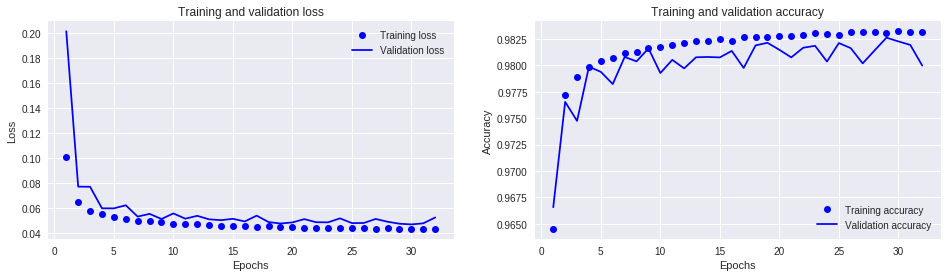

In [12]:
plot_history(history)

In [13]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 18s 578us/step
([0.0519077324736983, 0.9805420540967705], 0.9865322085676359)
